In [1]:
# Some of the code refered from: https://www.kaggle.com/svpons/feature-engineering

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# session

In [376]:
df_session = pd.read_csv('sessions.csv')

In [377]:
df_session.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,jpmpj40cvk,lookup,NaN,NaN,Windows Desktop,957.0
5,jpmpj40cvk,search_results,click,view_search_results,Windows Desktop,965.0
6,jpmpj40cvk,search_results,click,view_search_results,Windows Desktop,1021.0
7,jpmpj40cvk,search_results,click,view_search_results,Windows Desktop,938.0
8,jpmpj40cvk,search_results,click,view_search_results,Windows Desktop,2702.0
9,jpmpj40cvk,ajax_refresh_subtotal,click,change_trip_characteristics,Windows Desktop,674.0


In [378]:
df_session.isnull().sum()

user_id            2797
action             7873
action_type      143097
action_detail    143097
device_type           0
secs_elapsed      11067
dtype: int64

In [379]:
df_session.action = df_session.action.fillna("NAN")
df_session.action_type = df_session.action_type.fillna("NAN")
df_session.action_detail = df_session.action_detail.fillna("NAN")
df_session.device_type = df_session.device_type.fillna("NAN")

In [380]:
df_session.action.value_counts()
df_session.action_type.value_counts()
df_session.action_detail.value_counts()
df_session.device_type.value_counts()

Mac Desktop                         478574
Windows Desktop                     326346
Android App Unknown Phone/Tablet     98002
iPad Tablet                          72071
iPhone                               43406
-unknown-                            16245
Tablet                                5322
Linux Desktop                         3552
Chromebook                            3075
Android Phone                         1606
iPodtouch                              289
Blackberry                              53
Windows Phone                           29
Opera Phone                              5
Name: device_type, dtype: int64

In [381]:
# action values with low frequency are changed to "Other"

# threshold
act_freq = 100

act = dict(zip(*np.unique(df_session.action, return_counts=True)))
df_session.action = df_session.action.apply(lambda x : "Other" if act[x] < act_freq else x)

In [382]:
f_act = df_session.action.value_counts().argsort()
f_act_detail = df_session.action_detail.value_counts().argsort()
f_act_type = df_session.action_type.value_counts().argsort()
f_dev_type = df_session.device_type.value_counts().argsort()

In [383]:
print(f_act.size)
print(f_act_detail.size)
print(f_act_type.size)
print(f_dev_type.size)

117
108
10
14


In [384]:
#group session by id.
dgr_sess = df_session.groupby(['user_id'])

In [385]:
len(dgr_sess)

15588

In [386]:
# loop on dgr_sess to create all the features
samples = []
count = 0
ln = len(dgr_sess)

for g in dgr_sess:
    gr = g[1] # date frame that contains all the data from eahc groupby value(user_id)
    
    l = []
    
    # the id
    l.append(g[0])
    
    # number of total actions
    l.append(len(gr))
    
    sev = gr.secs_elapsed.fillna(0).values
    
    #action features
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values):
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    #action_detail features
    c_act_detail = [0] * len(f_act_detail)
    for i, v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    #action_type features
    #l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        #l_act_type[f_act_type[v]] += sev[i]
        c_act_type[f_act_type[v]] += 1
    #l_act_type = np.log(1 + np.array(l_act_type)).tolist()
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts = True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    #1 = 1 + c_act_type + l_act_type
    l = l + c_act_type
    
    #device_type features
    c_dev_type = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type.values):
        c_dev_type[f_dev_type[v]] += 1
    c_dev_type.append(len(np.unique(gr.device_type.values)))
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts = True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]
    l = l + c_dev_type
    
    #secs_elapsed features
    l_secs = [0] * 5
    l_log = [0] * 15
    if len(sev) > 0:
        #simpale statistics
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev))
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1])
        
        #values are grouped in 15 intervals
        log_sev = np.log(1 + sev).astype(int)
        l_log = np.bincount(log_sev, minlength = 15).tolist()
    l = l + l_secs + l_log
    
    samples.append(l)
    count += 1

In [387]:
len(samples)

15588

In [388]:
samples = np.array(samples)
samples

array([['007gj7kqdk', '9', '0', ..., '1', '0', '0'],
       ['009a40t3dk', '26', '0', ..., '1', '2', '0'],
       ['00allnceb8', '1', '0', ..., '0', '0', '0'],
       ..., 
       ['zzv8sgicbk', '25', '0', ..., '1', '0', '0'],
       ['zzvatt4dio', '422', '0', ..., '8', '3', '2'],
       ['zzywmcn0jv', '51', '0', ..., '2', '2', '0']], 
      dtype='<U16')

In [389]:
sample_ar = samples[:,1:].astype(np.float16)
sample_id = samples[:,0] # the first element(user_id)

In [390]:
sample_ar

array([[   9.,    0.,    0., ...,    1.,    0.,    0.],
       [  26.,    0.,    0., ...,    1.,    2.,    0.],
       [   1.,    0.,    0., ...,    0.,    0.,    0.],
       ..., 
       [  25.,    0.,    0., ...,    1.,    0.,    0.],
       [ 422.,    0.,    0., ...,    8.,    3.,    2.],
       [  51.,    0.,    0., ...,    2.,    2.,    0.]], dtype=float16)

In [391]:
sample_id

array(['007gj7kqdk', '009a40t3dk', '00allnceb8', ..., 'zzv8sgicbk',
       'zzvatt4dio', 'zzywmcn0jv'], 
      dtype='<U16')

In [399]:
# create dateframe
col_names = []
for i in range(len(samples[0]) - 1):
    col_names.append('c_' + str(i))

df_agg_sess = pd.DataFrame(sample_ar, columns = col_names)
df_agg_sess.id = pd.Series(sample_id)
#df_agg_sess.index = df_agg_sess.id

# -------- finish cleanning of session---------

# training and testing data

In [132]:
train = pd.read_csv("train_users.csv")
test = pd.read_csv("test_users.csv")

In [433]:
train_row = train.shape[0]

In [134]:
test.shape

(62096, 15)

In [135]:
train.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [136]:
print('training dataset null value')
print(train.isnull().sum(axis=0))
print('--------------------------')
print('test dataset null value')
print(test.isnull().sum(axis=0))

training dataset null value
id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64
--------------------------
test dataset null value
id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
f

In [137]:
# drop date_frist_booking attribute
train.drop(['date_first_booking'], axis = 1, inplace=True)
test.drop(['date_first_booking'], axis = 1, inplace=True)

In [138]:
train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [139]:
# the labels we need to predict
labels = train.country_destination.values
train.drop(['country_destination'], axis = 1, inplace=True)

In [140]:
labels
id_test = test['id']

preparing training and testing data

In [141]:
# join the two set (one hot encoding)
df = pd.concat([train, test], axis = 0, ignore_index = True)
df.shape

(275547, 14)

timestamp_first_active

In [142]:
import datetime

In [143]:
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int (x[0:4]),
                                                                             int (x[4:6]),
                                                                             int (x[6:8]),
                                                                             int (x[8:10]),
                                                                             int (x[10:12]),
                                                                             int (x[12:])))

In [144]:
tfa.sample(5)

8425     2011-08-29 15:23:39
51697    2012-12-10 01:34:05
10960    2011-10-10 19:54:18
212566   2014-06-29 10:28:15
108308   2013-09-17 07:21:00
Name: timestamp_first_active, dtype: datetime64[ns]

In [145]:
# create feature(year, month, week)
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_week'] = np.array([x.week for x in tfa])

In [146]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_week'],
      dtype='object')

In [147]:
#create weekday by one hot coding
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa])
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')
df = pd.concat((df, df_tfa_wd), axis = 1)
df.drop(['tfa_wd'], axis = 1, inplace=True)
df.sample(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,tfa_year,tfa_month,tfa_week,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7
156970,hp9bxlcrjj,2014-02-26,20140226011017,-unknown-,NaN,basic,25,en,direct,direct,...,2014,2,9,0,0,1,0,0,0,0
152066,wmpfxn6iag,2014-02-12,20140212064240,FEMALE,30.0,facebook,0,en,direct,direct,...,2014,2,7,0,0,1,0,0,0,0


In [148]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_week', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4', 'tfa_wd_5',
       'tfa_wd_6', 'tfa_wd_7'],
      dtype='object')

In [149]:
from datetime import date

In [150]:
Y = 2000
seasons = [(0, (date(Y, 1, 1),   date(Y, 3, 20))), #winter
           (1, (date(Y, 3, 21),  date(Y, 6, 20))), #spring
           (2, (date(Y, 6, 21),  date(Y, 9, 22))), #summer
           (3, (date(Y, 9, 23),  date(Y, 12, 20))),#autumn
           (0, (date(Y, 12, 21), date(Y, 12, 31)))]#winter

In [151]:
seasons

[(0, (datetime.date(2000, 1, 1), datetime.date(2000, 3, 20))),
 (1, (datetime.date(2000, 3, 21), datetime.date(2000, 6, 20))),
 (2, (datetime.date(2000, 6, 21), datetime.date(2000, 9, 22))),
 (3, (datetime.date(2000, 9, 23), datetime.date(2000, 12, 20))),
 (0, (datetime.date(2000, 12, 21), datetime.date(2000, 12, 31)))]

In [152]:
def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year = Y)
    return next(season for season, (start, end) in seasons if start <= dt <= end)

In [153]:
df['tfa_season'] = np.array([get_season(dt) for dt in tfa])

In [154]:
#one hot encoding
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season')
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True)

In [155]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_week', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4', 'tfa_wd_5',
       'tfa_wd_6', 'tfa_wd_7', 'tfa_season_0', 'tfa_season_1', 'tfa_season_2',
       'tfa_season_3'],
      dtype='object')

date_account_created

In [157]:
dac = pd.to_datetime(df.date_account_created)

In [163]:
df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])

In [167]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_week', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4', 'tfa_wd_5',
       'tfa_wd_6', 'tfa_wd_7', 'tfa_season_0', 'tfa_season_1', 'tfa_season_2',
       'tfa_season_3', 'dac_year', 'dac_month', 'dac_day', 'dac_wd_1',
       'dac_wd_2', 'dac_wd_3', 'dac_wd_4', 'dac_wd_5', 'dac_wd_6', 'dac_wd_7'],
      dtype='object')

In [166]:
# one hot encoding
df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, 'dac_wd')
df = pd.concat((df, df_dac_wd), axis = 1)
df.drop(['dac_wd'], axis = 1, inplace= True)

In [171]:
# season feature
df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)

Time Span between dac and tfa

In [199]:
dt_span = dac.subtract(tfa).dt.days

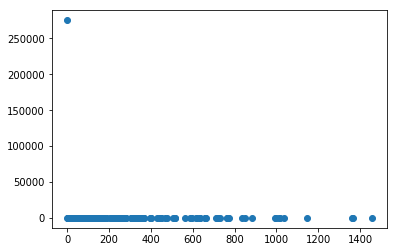

In [212]:
plt.scatter(dt_span.value_counts().index.values, dt_span.value_counts().values)

In [218]:
dt_span.unique()

array([ 465,  731,  475,  764,  279,   -1,  311,  100,    6,  261,  355,
        215, 1368,    5,  162, 1455,  664,  307, 1360,  353,  273,  217,
         75,  348,  850,  994,    1,  997,  153, 1035,  615,  721,  515,
       1010, 1147,   19,  767,   90,  447,   12,    3,  336,  398,  709,
       1017,  327,    0,    2,  310,  240,   77,  717,  303,  258,  302,
         61,  657,  837,  166,  506,  238,  400,  282,  881,  635,   36,
        450,   15,  564,  633,  357,  136,  313,   94,  773,  168,   30,
        203,  762,  586,   39,   56,  124,  123,   46,  175,  658,  594,
        513,   17,   43,   85,  430,  128,  321,  621,  233,   79,    4,
        137,   64,   28,  394,   91,  152,   10,  437,  102,  366,  368,
        446,  363,  132,  209,  361,  236,  117,  248,   16,  142,  115,
        107,  228,  330,   73,  149,  145,  358,  188,  257,    8,  103,
         45,  178,    9,  131,  245,  242,   34,   20,  105,  110,  143])

In [222]:
# cretae categorical feature
def get_span(dt):
    if(dt == -1):
        return "OneDay"
    elif(dt < 30) & (dt > -1):
        return "OneMonth"
    elif(dt >= 30) & (dt <= 365):
        return "OneYear"
    else:
        return "Other"

In [223]:
df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, "dt_span")
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)

In [224]:
df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3,dt_span_OneDay,dt_span_OneMonth,dt_span_OneYear,dt_span_Other
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,...,0,0,0,0,1,0,0,0,0,1
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,0,0,0,1,0,0,0,0,0,1
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,0,0,0,0,0,1,0,0,0,1
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,0,1,0,0,0,1
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,...,0,0,0,0,1,0,0,0,1,0


In [226]:
# drop featured columns
df.drop(['date_account_created', 'timestamp_first_active'], axis = 1, inplace = True)

In [228]:
df.columns

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', 'tfa_year',
       'tfa_month', 'tfa_week', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4',
       'tfa_wd_5', 'tfa_wd_6', 'tfa_wd_7', 'tfa_season_0', 'tfa_season_1',
       'tfa_season_2', 'tfa_season_3', 'dac_year', 'dac_month', 'dac_day',
       'dac_wd_1', 'dac_wd_2', 'dac_wd_3', 'dac_wd_4', 'dac_wd_5', 'dac_wd_6',
       'dac_wd_7', 'dac_season_0', 'dac_season_1', 'dac_season_2',
       'dac_season_3', 'dt_span_OneDay', 'dt_span_OneMonth', 'dt_span_OneYear',
       'dt_span_Other'],
      dtype='object')

#### Age

In [300]:
av = df.age.fillna(-1).values

In [301]:
av = np.where(np.logical_and(av < 2000, av > 1900), 2019- av, av)

In [304]:
div = 15

def get_age(age):
    # age is a float number
    if age < 0:
        return 'NA'
    elif (age < div):
        return div
    elif (age <= div * 2):
        return div*2
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical'

In [307]:
df['age'] = np.array([get_age(x) for x in av])
df_age = pd.get_dummies(df.age, prefix = "age")
df = pd.concat((df, df_age), axis = 1)
df.drop(['age'], axis = 1, inplace = True)

In [313]:
df.columns

Index(['id', 'gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', 'tfa_year',
       'tfa_month', 'tfa_week', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4',
       'tfa_wd_5', 'tfa_wd_6', 'tfa_wd_7', 'tfa_season_0', 'tfa_season_1',
       'tfa_season_2', 'tfa_season_3', 'dac_year', 'dac_month', 'dac_day',
       'dac_wd_1', 'dac_wd_2', 'dac_wd_3', 'dac_wd_4', 'dac_wd_5', 'dac_wd_6',
       'dac_wd_7', 'dac_season_0', 'dac_season_1', 'dac_season_2',
       'dac_season_3', 'dt_span_OneDay', 'dt_span_OneMonth', 'dt_span_OneYear',
       'dt_span_Other', 'age_15', 'age_30', 'age_45', 'age_60', 'age_75',
       'age_90', 'age_NA', 'age_Unphysical'],
      dtype='object')

#### one hot encoding categorical features

In [314]:
# pay attention to the 'first_affiliate_tracked' when OHE since this one has missing values. 

feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']

In [315]:
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_ohe), axis = 1)

In [317]:
df.columns

Index(['id', 'tfa_year', 'tfa_month', 'tfa_week', 'tfa_wd_1', 'tfa_wd_2',
       'tfa_wd_3', 'tfa_wd_4', 'tfa_wd_5', 'tfa_wd_6',
       ...
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_UC Browser', 'first_browser_Yandex.Browser',
       'first_browser_wOSBrowser', 'first_browser_nan'],
      dtype='object', length=204)

In [319]:
df.shape

(275547, 204)

In [354]:
df_agg_sess.id

array(['007gj7kqdk', '009a40t3dk', '00allnceb8', ..., 'zzv8sgicbk',
       'zzvatt4dio', 'zzywmcn0jv'], 
      dtype='<U16')

Merge with sess

In [420]:
df_all = pd.merge(df, df_agg_sess,left_index=True, right_index=True,how="left")


In [423]:
df_all.drop(['id'], axis = 1, inplace = True)

In [428]:
df_all.index = range(df_all.shape[0])

In [430]:
df_all.fillna(-2) ##missing feature for samples without session

,tfa_year,tfa_month,tfa_week,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_273,c_274,c_275,c_276,c_277,c_278,c_279,c_280,c_281,c_282
0,2009,3,12,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,2009,5,21,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,2009,6,24,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,2009,10,44,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,2009,12,50,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
5,2010,1,53,0,0,0,0,1,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
6,2010,1,53,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
7,2010,1,53,0,0,0,0,0,0,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
8,2010,1,1,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
9,2010,1,1,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


# spli the train and test dataset now

In [434]:
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]

In [438]:
Xtrain.to_csv("xtrain.csv")
Xtest.to_csv("xtest.csv")